# KDE

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, DensityMixin
from sklearn.neighbors import KernelDensity
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [132]:
class MyKDE(BaseEstimator, DensityMixin):
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def _gaussian_kernel(self, u):
        return (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)
    
    def _square_kernel(self, u):
        return 0.5 * (np.abs(u) <= 1.0)
    
    def _epanechnikov_kernel(self, u):
        return 0.75 * (1 - u**2) * (np.abs(u) <= 1.0)
    
    def _get_kernel_function(self):
        if self.kernel == 'gaussian':
            return self._gaussian_kernel
        elif self.kernel == 'tophat':
            return self._square_kernel
        elif self.kernel == 'epanechnikov':
            return self._epanechnikov_kernel

    def fit(self, X, y=None):
        X = np.asarray(X)
        self.X_train_ = X
        self.n_samples_ = len(X)
        return self
    
    def score_samples(self, X):
        X = np.asarray(X)

        kernel_func = self._get_kernel_function()
        densities = np.zeros(len(X))
        
        for i, x in enumerate(X):
            # Вычисляем расстояния от точки x до всех обучающих точек
            distances = (x - self.X_train_) / self.bandwidth
            # Применяем ядро и усредняем
            kernel_values = kernel_func(distances)
            densities[i] = np.mean(kernel_values) / self.bandwidth
        
        # Возвращаем log-плотность, избегая log(0)
        densities = np.maximum(densities, 1e-10)
        return np.log(densities)
    
    def score(self, X, y=None):
        return np.mean(self.score_samples(X))
    
    def predict_proba(self, X):
        return np.exp(self.score_samples(X))


Сгенерировано 300 точек из смеси двух нормальных распределений
Статистики: μ=4.01, σ=2.31


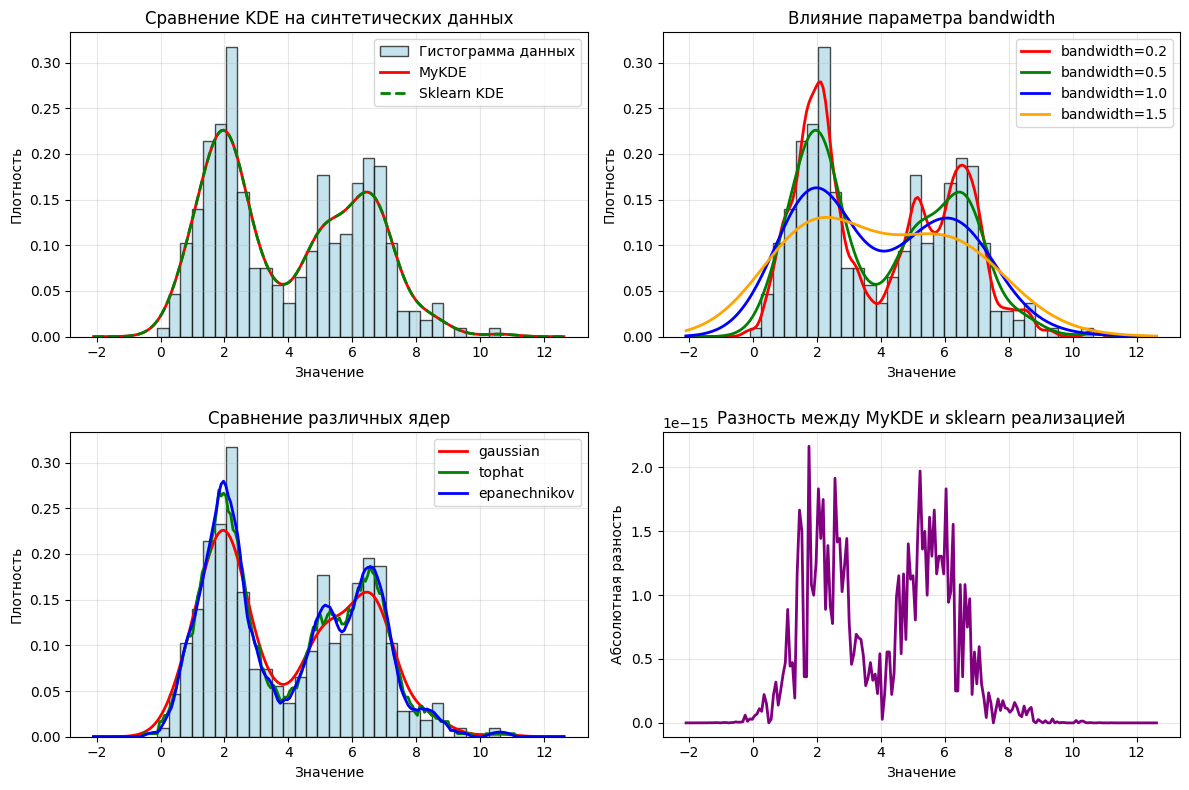


Численные сравнения:
Максимальная абсолютная ошибка: 0.000000
Средняя абсолютная ошибка: 0.000000
Log-likelihood (MyKDE): -2.0235
Log-likelihood (sklearn): -607.0625


In [133]:
np.random.seed(42)
n_samples = 300

# Первая компонента: μ=2, σ=0.8
component1 = np.random.normal(2, 0.8, n_samples//2)
# Вторая компонента: μ=6, σ=1.2
component2 = np.random.normal(6, 1.2, n_samples//2)

synthetic_data = np.concatenate([component1, component2])
np.random.shuffle(synthetic_data)

print(f"Сгенерировано {len(synthetic_data)} точек из смеси двух нормальных распределений")
print(f"Статистики: μ={synthetic_data.mean():.2f}, σ={synthetic_data.std():.2f}")

x_grid = np.linspace(synthetic_data.min() - 2, synthetic_data.max() + 2, 200)

kde_simple = MyKDE(bandwidth=0.5, kernel='gaussian')
kde_simple.fit(synthetic_data)
density_simple = kde_simple.predict_proba(x_grid)

kde_sklearn = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde_sklearn.fit(synthetic_data.reshape(-1, 1))
density_sklearn = np.exp(kde_sklearn.score_samples(x_grid.reshape(-1, 1)))

# Визуализация результатов
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(synthetic_data, bins=30, density=True, alpha=0.7, color='lightblue', 
         edgecolor='black', label='Гистограмма данных')
plt.plot(x_grid, density_simple, 'r-', linewidth=2, label='MyKDE')
plt.plot(x_grid, density_sklearn, 'g--', linewidth=2, label='Sklearn KDE')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.title('Сравнение KDE на синтетических данных')
plt.legend()
plt.grid(True, alpha=0.3)

# Сравнение разных bandwidth
plt.subplot(2, 2, 2)
plt.hist(synthetic_data, bins=30, density=True, alpha=0.7, color='lightblue', edgecolor='black')

bandwidths = [0.2, 0.5, 1.0, 1.5]
colors = ['red', 'green', 'blue', 'orange']

for bw, color in zip(bandwidths, colors):
    kde_temp = MyKDE(bandwidth=bw, kernel='gaussian')
    kde_temp.fit(synthetic_data)
    density_temp = kde_temp.predict_proba(x_grid)
    plt.plot(x_grid, density_temp, color=color, linewidth=2, label=f'bandwidth={bw}')

plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.title('Влияние параметра bandwidth')
plt.legend()
plt.grid(True, alpha=0.3)

# Сравнение разных ядер
plt.subplot(2, 2, 3)
plt.hist(synthetic_data, bins=30, density=True, alpha=0.7, color='lightblue', edgecolor='black')

kernels = ['gaussian', 'tophat', 'epanechnikov']
colors = ['red', 'green', 'blue']

for kernel, color in zip(kernels, colors):
    kde_temp = MyKDE(bandwidth=0.5, kernel=kernel)
    kde_temp.fit(synthetic_data)
    density_temp = kde_temp.predict_proba(x_grid)
    plt.plot(x_grid, density_temp, color=color, linewidth=2, label=f'{kernel}')

plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.title('Сравнение различных ядер')
plt.legend()
plt.grid(True, alpha=0.3)

# Точность аппроксимации
plt.subplot(2, 2, 4)
difference = np.abs(density_simple - density_sklearn)
plt.plot(x_grid, difference, 'purple', linewidth=2)
plt.xlabel('Значение')
plt.ylabel('Абсолютная разность')
plt.title('Разность между MyKDE и sklearn реализацией')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Численные сравнения
print("\nЧисленные сравнения:")
print(f"Максимальная абсолютная ошибка: {np.max(difference):.6f}")
print(f"Средняя абсолютная ошибка: {np.mean(difference):.6f}")
print(f"Log-likelihood (MyKDE): {kde_simple.score(synthetic_data):.4f}")
print(f"Log-likelihood (sklearn): {kde_sklearn.score(synthetic_data.reshape(-1, 1)):.4f}")

Описание датасета Iris:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)     species  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  

Размер датасета: (150, 5)
Классы: ['setosa', 'v

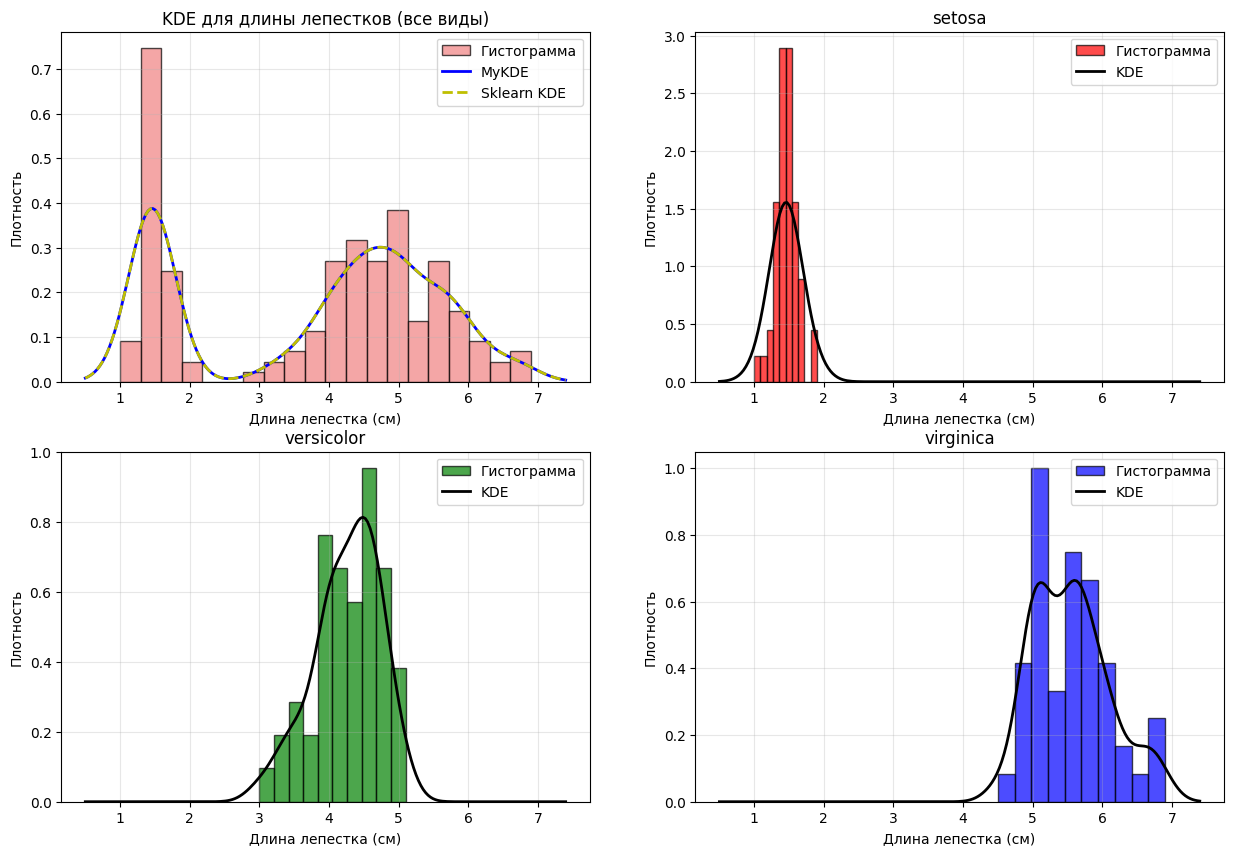

In [134]:
# Загружаем данные Iris
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target

print("Описание датасета Iris:")
print(iris_df.describe())
print(f"\nРазмер датасета: {iris_df.shape}")
print(f"Классы: {list(iris.target_names)}")

# Возьмем длину лепестков для анализа
petal_length = iris_df['petal length (cm)'].values
print(f"\nАнализируем признак 'petal length (cm)'")
print(f"Статистики: μ={petal_length.mean():.2f}, σ={petal_length.std():.2f}")

x_grid_iris = np.linspace(petal_length.min() - 0.5, petal_length.max() + 0.5, 200)

kde_iris = MyKDE(bandwidth=0.3, kernel='gaussian')
kde_iris.fit(petal_length)
density_iris = kde_iris.predict_proba(x_grid_iris)

kde_sklearn_iris = KernelDensity(bandwidth=0.3, kernel='gaussian')
kde_sklearn_iris.fit(petal_length.reshape(-1, 1))
density_sklearn_iris = np.exp(kde_sklearn_iris.score_samples(x_grid_iris.reshape(-1, 1)))

# Визуализация
plt.figure(figsize=(15, 10))

# Общее распределение
plt.subplot(2, 2, 1)
plt.hist(petal_length, bins=20, density=True, alpha=0.7, color='lightcoral', 
         edgecolor='black', label='Гистограмма')
plt.plot(x_grid_iris, density_iris, 'b-', linewidth=2, label='MyKDE')
plt.plot(x_grid_iris, density_sklearn_iris, 'y--', linewidth=2, label='Sklearn KDE')
plt.xlabel('Длина лепестка (см)')
plt.ylabel('Плотность')
plt.title('KDE для длины лепестков (все виды)')
plt.legend()
plt.grid(True, alpha=0.3)

# Распределения по видам
species_names = iris.target_names
colors = ['red', 'green', 'blue']

for i, (species, color) in enumerate(zip(species_names, colors)):
    plt.subplot(2, 2, i + 2)
    
    # Данные для конкретного вида
    species_data = petal_length[iris.target == i]
    
    # Гистограмма
    plt.hist(species_data, bins=10, density=True, alpha=0.7, color=color, 
             edgecolor='black', label='Гистограмма')
    
    # KDE для данного вида
    kde_species = MyKDE(bandwidth=0.2, kernel='gaussian')
    kde_species.fit(species_data)
    density_species = kde_species.predict_proba(x_grid_iris)
    
    plt.plot(x_grid_iris, density_species, 'black', linewidth=2, label='KDE')
    plt.xlabel('Длина лепестка (см)')
    plt.ylabel('Плотность')
    plt.title(f'{species}')
    plt.legend()
    plt.grid(True, alpha=0.3)

___
# Gradient Boosting

In [135]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import matplotlib.pyplot as plt

In [136]:

class MyGradientBoostingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators_ = []
        self.initial_prediction_ = None
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        # Начальное предсказание - среднее значение
        self.initial_prediction_ = np.mean(y)
        
        # Инициализация остатков
        residuals = y - self.initial_prediction_
        
        for i in range(self.n_estimators):
            # Создаем базовый алгоритм (решающее дерево)
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state + i if self.random_state else None
            )
            
            # Обучаем на остатках
            tree.fit(X, residuals)
            
            # Делаем предсказание
            prediction = tree.predict(X)
            
            # Обновляем остатки
            residuals -= self.learning_rate * prediction
            
            # Сохраняем обученное дерево
            self.estimators_.append(tree)
            
        return self
    
    def predict(self, X):
        X = np.array(X)
        
        # Начинаем с начального предсказания
        prediction = np.full(X.shape[0], self.initial_prediction_)
        
        # Добавляем предсказания всех деревьев
        for tree in self.estimators_:
            prediction += self.learning_rate * tree.predict(X)
            
        return prediction

class MyGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators_ = []
        self.classes_ = None
        self.n_classes_ = None
        self.initial_prediction_ = None
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        # Определяем классы
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        if self.n_classes_ == 2:
            # Бинарная классификация
            # Преобразуем метки в 0 и 1
            y_binary = (y == self.classes_[1]).astype(int)
            
            # Начальное предсказание - логит от пропорции положительных примеров
            p = np.mean(y_binary)
            p = np.clip(p, 1e-15, 1 - 1e-15)  # избегаем деления на 0
            self.initial_prediction_ = np.log(p / (1 - p))
            
            # Инициализация текущих предсказаний
            current_pred = np.full(len(y), self.initial_prediction_)
            
            for i in range(self.n_estimators):
                # Вычисляем вероятности
                probabilities = self._sigmoid(current_pred)
                
                # Вычисляем остатки (градиент логистической функции потерь)
                residuals = y_binary - probabilities
                
                # Создаем базовый алгоритм
                tree = DecisionTreeRegressor(
                    max_depth=self.max_depth,
                    random_state=self.random_state + i if self.random_state else None
                )
                
                # Обучаем на остатках
                tree.fit(X, residuals)
                
                # Делаем предсказание
                prediction = tree.predict(X)
                
                # Обновляем текущие предсказания
                current_pred += self.learning_rate * prediction
                
                # Сохраняем обученное дерево
                self.estimators_.append(tree)
        else:
            raise NotImplementedError("Пока поддерживается только бинарная классификация")
            
        return self
    
    def predict_proba(self, X):
        X = np.array(X)
        
        if self.n_classes_ == 2:
            # Начинаем с начального предсказания
            prediction = np.full(X.shape[0], self.initial_prediction_)
            
            # Добавляем предсказания всех деревьев
            for tree in self.estimators_:
                prediction += self.learning_rate * tree.predict(X)
            
            # Преобразуем в вероятности
            prob_class_1 = self._sigmoid(prediction)
            prob_class_0 = 1 - prob_class_1
            
            return np.column_stack([prob_class_0, prob_class_1])
        else:
            raise NotImplementedError("Пока поддерживается только бинарная классификация")
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        return self.classes_[np.argmax(probabilities, axis=1)]

In [137]:
X_reg, y_reg = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

my_gb_reg = MyGradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
my_gb_reg.fit(X_train_reg, y_train_reg)
my_pred_reg = my_gb_reg.predict(X_test_reg)

sklearn_gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
sklearn_gb_reg.fit(X_train_reg, y_train_reg)
sklearn_pred_reg = sklearn_gb_reg.predict(X_test_reg)

# Сравнение результатов
my_mse = mean_squared_error(y_test_reg, my_pred_reg)
sklearn_mse = mean_squared_error(y_test_reg, sklearn_pred_reg)

print(f"MSE MyGradientBoostingRegressor: {my_mse:.4f}")
print(f"MSE sklearn: {sklearn_mse:.4f}")
print(f"Разница: {abs(my_mse - sklearn_mse):.4f}")


MSE MyGradientBoostingRegressor: 1244.1138
MSE sklearn: 1234.7530
Разница: 9.3609


In [138]:
from sklearn.datasets import make_classification
X_clf, y_clf = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

my_gb_clf = MyGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
my_gb_clf.fit(X_train_clf, y_train_clf)
my_pred_clf = my_gb_clf.predict(X_test_clf)

sklearn_gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
sklearn_gb_clf.fit(X_train_clf, y_train_clf)
sklearn_pred_clf = sklearn_gb_clf.predict(X_test_clf)

# Сравнение результатов
my_acc = accuracy_score(y_test_clf, my_pred_clf)
sklearn_acc = accuracy_score(y_test_clf, sklearn_pred_clf)

print(f"Accuracy MyGradientBoostingClassifier: {my_acc:.4f}")
print(f"Accuracy sklearn: {sklearn_acc:.4f}")
print(f"Разница: {abs(my_acc - sklearn_acc):.4f}")

Accuracy MyGradientBoostingClassifier: 0.9050
Accuracy sklearn: 0.9000
Разница: 0.0050


In [139]:
# Загружаем датасет Iris
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Преобразуем в бинарную классификацию (setosa vs не setosa)
y_iris_binary = (y_iris == 0).astype(int)

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris_binary, test_size=0.3, random_state=42
)

my_gb_iris = MyGradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
my_gb_iris.fit(X_train_iris, y_train_iris)
my_pred_iris = my_gb_iris.predict(X_test_iris)
my_proba_iris = my_gb_iris.predict_proba(X_test_iris)

sklearn_gb_iris = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
sklearn_gb_iris.fit(X_train_iris, y_train_iris)
sklearn_pred_iris = sklearn_gb_iris.predict(X_test_iris)

# Сравнение результатов
my_acc_iris = accuracy_score(y_test_iris, my_pred_iris)
sklearn_acc_iris = accuracy_score(y_test_iris, sklearn_pred_iris)

print(f"Accuracy MyGradientBoostingClassifier на Iris: {my_acc_iris:.4f}")
print(f"Accuracy sklearn на Iris: {sklearn_acc_iris:.4f}")
print(f"Разница: {abs(my_acc_iris - sklearn_acc_iris):.4f}")

Accuracy MyGradientBoostingClassifier на Iris: 1.0000
Accuracy sklearn на Iris: 1.0000
Разница: 0.0000


___
# Radial basis kernel regression

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_iris
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler


In [141]:
class RBFKernelRegression(BaseEstimator, RegressorMixin):  
    def __init__(self, gamma=1.0, alpha=1.0):
        self.gamma = gamma
        self.alpha = alpha
        
    def _rbf_kernel(self, X1, X2):
        # Вычисляем квадрат евклидова расстояния
        sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + \
                   np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        
        # Применяем RBF ядро
        return np.exp(-self.gamma * sq_dists)
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем обучающие данные для предсказаний
        self.X_train_ = X.copy()
        self.y_train_ = y.copy()
        
        # Вычисляем матрицу ядра для обучающих данных
        K = self._rbf_kernel(X, X)
        
        # Добавляем регуляризацию (Ridge)
        K_reg = K + self.alpha * np.eye(K.shape[0])
        
        # Решаем систему линейных уравнений: (K + αI)α = y
        self.alpha_coef_ = np.linalg.solve(K_reg, y)
        
        return self
    
    def predict(self, X):
        X = np.array(X)
        
        # Вычисляем матрицу ядра между тестовыми и обучающими данными
        K_test = self._rbf_kernel(X, self.X_train_)
        
        # Предсказание: y = K_test * alpha_coef
        return np.dot(K_test, self.alpha_coef_)


RBFKernelRegression - MSE: 0.0347, R²: 0.9455
Sklearn KernelRidge - MSE: 0.0347, R²: 0.9455
Разность предсказаний (средняя): 0.000000


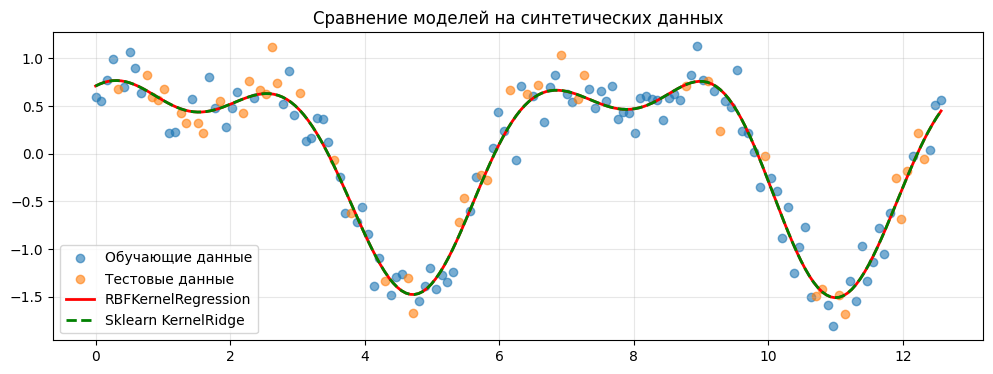

In [142]:
n_samples = 150
noise = 0.2
random_state = 42

np.random.seed(random_state)
X = np.linspace(0, 4*np.pi, n_samples).reshape(-1, 1)
y = np.sin(X).ravel() + 0.5 * np.cos(2*X).ravel() + noise * np.random.randn(n_samples)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

my_model = RBFKernelRegression(gamma=0.5, alpha=0.1)
my_model.fit(X_train, y_train)
my_pred = my_model.predict(X_test)

sklearn_model = KernelRidge(kernel='rbf', gamma=0.5, alpha=0.1)
sklearn_model.fit(X_train, y_train)
sklearn_pred = sklearn_model.predict(X_test)

# Метрики
my_mse = mean_squared_error(y_test, my_pred)
my_r2 = r2_score(y_test, my_pred)
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
sklearn_r2 = r2_score(y_test, sklearn_pred)

print(f"RBFKernelRegression - MSE: {my_mse:.4f}, R²: {my_r2:.4f}")
print(f"Sklearn KernelRidge - MSE: {sklearn_mse:.4f}, R²: {sklearn_r2:.4f}")
print(f"Разность предсказаний (средняя): {np.mean(np.abs(my_pred - sklearn_pred)):.6f}")

# Визуализация
plt.figure(figsize=(12, 4))

X_plot = np.linspace(0, 4*np.pi, 200).reshape(-1, 1)
y_plot_our = my_model.predict(X_plot)
y_plot_sklearn = sklearn_model.predict(X_plot)

plt.scatter(X_train, y_train, alpha=0.6, label='Обучающие данные')
plt.scatter(X_test, y_test, alpha=0.6, label='Тестовые данные')
plt.plot(X_plot, y_plot_our, 'r-', label='RBFKernelRegression', linewidth=2)
plt.plot(X_plot, y_plot_sklearn, 'g--', label='Sklearn KernelRidge', linewidth=2)
plt.title('Сравнение моделей на синтетических данных')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Подбор гиперпараметров:
γ=0.1, α=0.01: R²=0.9776, MSE=0.0754
γ=0.1, α=0.1: R²=0.9703, MSE=0.1000
γ=0.1, α=1.0: R²=0.9328, MSE=0.2265
γ=0.5, α=0.01: R²=0.9389, MSE=0.2059
γ=0.5, α=0.1: R²=0.9368, MSE=0.2130
γ=0.5, α=1.0: R²=0.8304, MSE=0.5719
γ=1.0, α=0.01: R²=0.8701, MSE=0.4381
γ=1.0, α=0.1: R²=0.8580, MSE=0.4789
γ=1.0, α=1.0: R²=0.6808, MSE=1.0762
γ=2.0, α=0.01: R²=0.7089, MSE=0.9817
γ=2.0, α=0.1: R²=0.6696, MSE=1.1141
γ=2.0, α=1.0: R²=0.3779, MSE=2.0975

Лучшие параметры: {'gamma': 0.1, 'alpha': 0.01}
Лучший R²: 0.9776

Финальное сравнение на датасете ирисов:
RBFKernelRegression - R²: 0.9776
Sklearn KernelRidge - R²: 0.9776


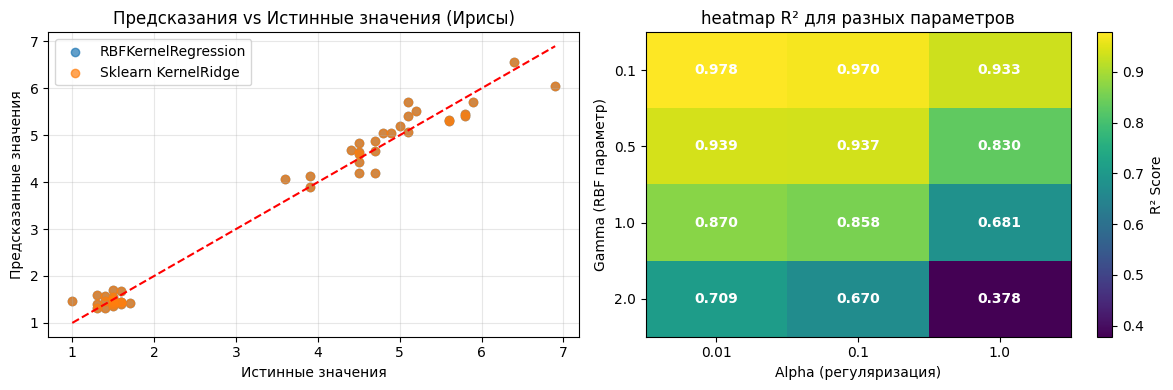

In [143]:
iris = load_iris()
X = iris.data

# Используем длину лепестка как целевую переменную
y = iris.data[:, 2]  # petal length
X_features = iris.data[:, [0, 1, 3]]  # остальные признаки

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.3, random_state=42
)

# Стандартизация данных (важно для RBF ядра)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Тестируем разные параметры
gammas = [0.1, 0.5, 1.0, 2.0]
alphas = [0.01, 0.1, 1.0]

best_score = -np.inf
best_params = {}
results = []

print("Подбор гиперпараметров:")
for gamma in gammas:
    for alpha in alphas:
        model = RBFKernelRegression(gamma=gamma, alpha=alpha)
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, pred)
        mse = mean_squared_error(y_test, pred)
        
        results.append({
            'gamma': gamma,
            'alpha': alpha,
            'r2': r2,
            'mse': mse
        })
        
        if r2 > best_score:
            best_score = r2
            best_params = {'gamma': gamma, 'alpha': alpha}
            
        print(f"γ={gamma}, α={alpha}: R²={r2:.4f}, MSE={mse:.4f}")

print(f"\nЛучшие параметры: {best_params}")
print(f"Лучший R²: {best_score:.4f}")

# Обучаем финальную модель с лучшими параметрами
final_model = RBFKernelRegression(**best_params)
final_model.fit(X_train_scaled, y_train)
final_pred = final_model.predict(X_test_scaled)

# Сравнение со sklearn
sklearn_model = KernelRidge(kernel='rbf', **best_params)
sklearn_model.fit(X_train_scaled, y_train)
sklearn_pred = sklearn_model.predict(X_test_scaled)

print(f"\nФинальное сравнение на датасете ирисов:")
print(f"RBFKernelRegression - R²: {r2_score(y_test, final_pred):.4f}")
print(f"Sklearn KernelRidge - R²: {r2_score(y_test, sklearn_pred):.4f}")

# Визуализация результатов
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test, final_pred, alpha=0.7, label='RBFKernelRegression')
plt.scatter(y_test, sklearn_pred, alpha=0.7, label='Sklearn KernelRidge')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказания vs Истинные значения (Ирисы)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
results_df = pd.DataFrame(results)
pivot_table = results_df.pivot(index='gamma', columns='alpha', values='r2')
plt.imshow(pivot_table.values, cmap='viridis', aspect='auto')
plt.colorbar(label='R² Score')
plt.xticks(range(len(alphas)), alphas)
plt.yticks(range(len(gammas)), gammas)
plt.xlabel('Alpha (регуляризация)')
plt.ylabel('Gamma (RBF параметр)')
plt.title('heatmap R² для разных параметров')

# Добавляем значения на карту
for i in range(len(gammas)):
    for j in range(len(alphas)):
        plt.text(j, i, f'{pivot_table.iloc[i, j]:.3f}', 
                ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

___
# AdaBoost

In [144]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

In [145]:
class MyAdaBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=50, learning_rate=1.0, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.random_state = random_state
        
    def fit(self, X, y):

        # Преобразуем входные данные
        X = np.array(X)
        y = np.array(y)
        
        # Инициализируем веса образцов равномерно
        n_samples = X.shape[0]
        sample_weights = np.ones(n_samples) / n_samples
        
        # Списки для хранения слабых классификаторов и их весов
        self.estimators_ = []
        self.estimator_weights_ = []
        self.estimator_errors_ = []
        
        # Преобразуем метки в {-1, +1}
        self.classes_ = np.unique(y)
        if len(self.classes_) != 2:
            raise ValueError("AdaBoost поддерживает только бинарную классификацию")
        
        y_encoded = np.where(y == self.classes_[0], -1, 1)
        
        for i in range(self.n_estimators):
            # Создаем слабый классификатор (пень решения)
            estimator = DecisionTreeClassifier(
                max_depth=1, 
                random_state=self.random_state
            )
            
            # Обучаем на взвешенной выборке
            estimator.fit(X, y, sample_weight=sample_weights)
            
            # Получаем предсказания
            y_pred = estimator.predict(X)
            y_pred_encoded = np.where(y_pred == self.classes_[0], -1, 1)
            
            # Вычисляем ошибку
            incorrect = y_pred_encoded != y_encoded
            error = np.sum(sample_weights * incorrect)
            
            # Если ошибка слишком большая или слишком маленькая, останавливаемся
            if error >= 0.5:
                if len(self.estimators_) == 0:
                    raise ValueError("Первый классификатор работает хуже случайного")
                break
                
            if error <= 0:
                # Идеальный классификатор
                self.estimators_.append(estimator)
                self.estimator_weights_.append(1.0)
                self.estimator_errors_.append(error)
                break
            
            # Вычисляем вес классификатора
            alpha = self.learning_rate * 0.5 * np.log((1 - error) / error)
            
            # Сохраняем классификатор и его вес
            self.estimators_.append(estimator)
            self.estimator_weights_.append(alpha)
            self.estimator_errors_.append(error)
            
            # Обновляем веса образцов
            sample_weights *= np.exp(alpha * incorrect * 2 - alpha)
            sample_weights /= np.sum(sample_weights)  # Нормализация
            
        return self
    
    def predict(self, X):
        X = np.array(X)
        
        # Получаем взвешенные предсказания всех классификаторов
        weighted_predictions = np.zeros(X.shape[0])
        
        for estimator, weight in zip(self.estimators_, self.estimator_weights_):
            pred = estimator.predict(X)
            pred_encoded = np.where(pred == self.classes_[0], -1, 1)
            weighted_predictions += weight * pred_encoded
        
        # Окончательное предсказание
        final_pred = np.where(weighted_predictions >= 0, self.classes_[1], self.classes_[0])
        
        return final_pred
    
    def predict_proba(self, X):
        X = np.array(X)
        
        # Получаем взвешенные предсказания
        weighted_predictions = np.zeros(X.shape[0])
        
        for estimator, weight in zip(self.estimators_, self.estimator_weights_):
            pred = estimator.predict(X)
            pred_encoded = np.where(pred == self.classes_[0], -1, 1)
            weighted_predictions += weight * pred_encoded
        
        # Преобразуем в вероятности через сигмоиду
        proba_class_1 = 1 / (1 + np.exp(-2 * weighted_predictions))
        proba_class_0 = 1 - proba_class_1
        
        return np.column_stack([proba_class_0, proba_class_1])


Размер обучающей выборки: (700, 2)
Размер тестовой выборки: (300, 2)
Классы: [0 1]

Обучение MyAdaBoost
Точность MyAdaBoost: 0.8767
Количество использованных классификаторов: 50
Точность sklearn реализации: 0.8767

Разность в точности: 0.0000


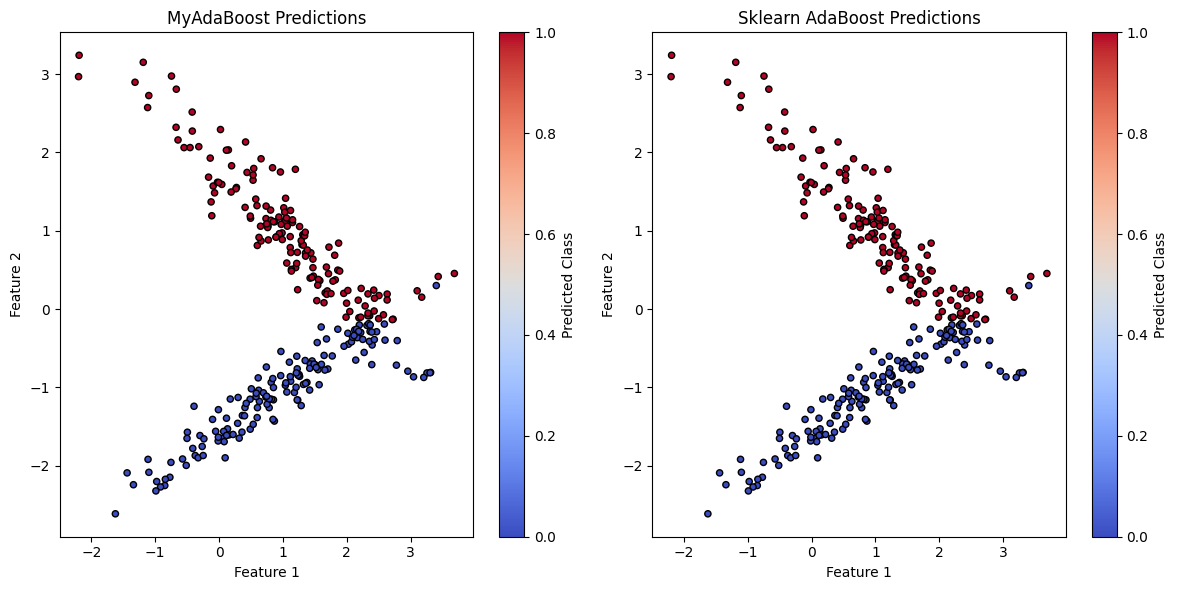

In [146]:
# Создаем синтетические данные
X_synthetic, y_synthetic = make_classification(
        n_samples=1000,
        n_features=2,
        n_redundant=0,
        n_informative=2,
        n_clusters_per_class=1,
        random_state=42
    )

X_train, X_test, y_train, y_test = train_test_split(
    X_synthetic, y_synthetic, test_size=0.3, random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Классы: {np.unique(y_synthetic)}\n")

print("Обучение MyAdaBoost")
our_ada = MyAdaBoost(n_estimators=50, learning_rate=1.0, random_state=42)
our_ada.fit(X_train, y_train)

our_pred = our_ada.predict(X_test)
our_accuracy = accuracy_score(y_test, our_pred)

print(f"Точность MyAdaBoost: {our_accuracy:.4f}")
print(f"Количество использованных классификаторов: {len(our_ada.estimators_)}")

sklearn_ada = AdaBoostClassifier(
    n_estimators=50, 
    learning_rate=1.0, 
    random_state=42,
    algorithm='SAMME'
)
sklearn_ada.fit(X_train, y_train)

sklearn_pred = sklearn_ada.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, sklearn_pred)

print(f"Точность sklearn реализации: {sklearn_accuracy:.4f}")

# Сравнение результатов
print(f"\nРазность в точности: {abs(our_accuracy - sklearn_accuracy):.4f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('MyAdaBoost Predictions')
plt.scatter(X_test[:, 0], X_test[:, 1], c=our_pred, cmap='coolwarm', edgecolor='k', s=20)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted Class')
plt.subplot(1, 2, 2)
plt.title('Sklearn AdaBoost Predictions')
plt.scatter(X_test[:, 0], X_test[:, 1], c=sklearn_pred, cmap='coolwarm', edgecolor='k', s=20)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted Class')
plt.tight_layout()
plt.show()

In [147]:

# Загружаем датасет ирисов и делаем его бинарным
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Берем только два класса для бинарной классификации
binary_mask = y_iris != 2  # Исключаем класс 'virginica'
X_iris_binary = X_iris[binary_mask]
y_iris_binary = y_iris[binary_mask]

print(f"Датасет Iris (бинарный):")
print(f"Размер выборки: {X_iris_binary.shape}")
print(f"Классы: {np.unique(y_iris_binary)} ({iris.target_names[0]}, {iris.target_names[1]})")

# Разделяем на обучающую и тестовую выборки
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris_binary, y_iris_binary, test_size=0.3, random_state=42
)

my_ada_iris = MyAdaBoost(n_estimators=50, learning_rate=1.0, random_state=42)
my_ada_iris.fit(X_train_iris, y_train_iris)

my_pred_iris = my_ada_iris.predict(X_test_iris)


sklearn_ada_iris = AdaBoostClassifier(
    n_estimators=50, 
    learning_rate=1.0, 
    random_state=42,
    algorithm='SAMME'
)
sklearn_ada_iris.fit(X_train_iris, y_train_iris)

sklearn_pred_iris = sklearn_ada_iris.predict(X_test_iris)


# Детальные отчеты
print("MyAdaBoost classification report:")
print(classification_report(y_test_iris, my_pred_iris, 
                            target_names=[iris.target_names[0], iris.target_names[1]]))

print("Sklearn classification report:")
print(classification_report(y_test_iris, sklearn_pred_iris, 
                            target_names=[iris.target_names[0], iris.target_names[1]]))


Датасет Iris (бинарный):
Размер выборки: (100, 4)
Классы: [0 1] (setosa, versicolor)
MyAdaBoost classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        17
  versicolor       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Sklearn classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        17
  versicolor       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

